In [101]:
import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit 
from sklearn import metrics as mt
from sklearn.metrics import roc_curve, auc
import operator
import sklearn.metrics as metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KDTree

### Import the data

In [2]:
directory = 'C:/githubrepo/7331_Project/data/'
df_zg = pd.read_csv(directory + 'Diabetic_Cleaned.csv')
print("Done reading data.")

Done reading data.


### Makes lists of the different types

In [3]:
ordinal = ["age", "time_in_hospital"]
categorical = ["race", "gender", "admission_type_id", "discharge_disposition_id",
               "admission_source_id", "medical_specialty", "max_glu_serum",
               "A1Cresult", "change", "diabetesMed", "diag_1_val", "diag_2_val",
               "diag_3_val", "meds_increased"]
continuous = ["num_lab_procedures", "num_procedures", "num_medications",
              "number_outpatient", "number_emergency", "number_inpatient",
              "number_diagnoses", "medication_count"]
lcontinuous = ["lnum_lab_procedures", "lnum_procedures", "lnum_medications",
              "lnumber_outpatient", "lnumber_emergency", "lnumber_inpatient",
              "lnumber_diagnoses", "lmedication_count"]
medicines = ["metformin", "repaglinide", "nateglinide", "chlorpropamide",
             "glimepiride", "acetohexamide", "glipizide", "glyburide", "tolbutamide",
             "pioglitazone", "rosiglitazone", "acarbose", "miglitol", "troglitazone",
             "tolazamide", "insulin", "glyburide-metformin", "glipizide-metformin",
             "metformin-rosiglitazone", "metformin-pioglitazone"]
response = ["readmitted_tf"]

### Dataframes of each type of data

In [4]:
df_zg_ordinal = df_zg[ordinal]
df_zg_categorical = df_zg[categorical]
df_zg_continuous = df_zg[continuous]
df_zg_lcontinuous = np.log(df_zg_continuous)
df_zg_lcontinuous.columns = lcontinuous
df_zg_medicines = df_zg[medicines]
df_zg_response = df_zg[response]

### Make Age ordinal

In [5]:
for i in range(0, 10):
    val = "[" + str(i*10) + "-" + str((i+1)*10) + ")"
    df_zg_ordinal.loc[df_zg_ordinal['age'] == val, 'age'] = i

### Making all categorical columns categorical

In [6]:
df_zg_categorical['admission_type_id'] = df_zg_categorical['admission_type_id'].astype(object)
df_zg_categorical['discharge_disposition_id'] = df_zg_categorical['discharge_disposition_id'].astype(object)
df_zg_categorical['admission_source_id'] = df_zg_categorical['admission_source_id'].astype(object)
df_zg_categorical['admission_type_id'] = df_zg_categorical['admission_type_id'].astype(object)
df_zg_categorical['meds_increased'] = df_zg_categorical['meds_increased'].astype(object)
#df_zg_response['readmitted_tf'] = df_zg_response['readmitted_tf'].astype(object)
print("Done")

Done


In [7]:
df_zg_x = pd.concat([df_zg_ordinal, df_zg_categorical, df_zg_continuous], axis = 1)
df_zg_num_x = pd.concat([df_zg_ordinal, df_zg_continuous], axis = 1)
df_zg_med_x = pd.concat([df_zg_ordinal, df_zg_categorical, df_zg_continuous, df_zg_medicines], axis = 1)
df_zg_hot_x = pd.concat([df_zg_ordinal, pd.get_dummies(df_zg_categorical), df_zg_continuous], axis = 1)
df_zg_hot_med_x = pd.concat([df_zg_ordinal, pd.get_dummies(df_zg_categorical), df_zg_continuous, pd.get_dummies(df_zg_medicines)], axis = 1)
df_zg_y = df_zg_response
print("Done")

Done


### Function for setting up the training, validation, and test sets

In [8]:
def tvt_split(df_x, df_y, valid_size, t_size, seed):
    #doing the math because we have to split 2 seperate times
    valid_size = 100*valid_size/(100*(1-t_size))
    #First splitting out the test set
    x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size = t_size, random_state=seed)
    #Splitting the training set into train/validate
    x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = valid_size, random_state=seed)

    #Reseting allof the indices
    x_train.reset_index()
    y_train.reset_index()
    x_test.reset_index()
    y_test.reset_index()
    x_valid.reset_index()
    y_valid.reset_index()

    return x_train, x_valid, x_test, y_train, y_valid, y_test

In [38]:
x_train, x_valid, x_test, y_train, y_valid, y_test = tvt_split(df_zg_hot_x, df_zg_y, 0.2, 0.2, 7)

#Print out the shapes of the train/valid/test sets
x_train.shape, x_valid.shape, x_test.shape

((61059, 184), (20353, 184), (20354, 184))

# KNN

In [42]:
%%time
#Create variables for just this operation
x_t = x_train
x_v = x_valid
y_t = y_train
y_v = y_valid

# We will fill this with predictions
yhat = np.zeros(y_v.shape)

scl = StandardScaler()
x_t = scl.fit_transform(x_train)
x_v = scl.fit_transform(x_train)

C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


Wall time: 1.08 s


C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [51]:
%%time
# get a handle to the classifier object, which defines the type
clf = KNeighborsClassifier(n_neighbors = 27)
clf.fit(x_t, y_t)

C:\ProgramData\Anaconda3\envs\DS7331_35r\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Wall time: 5.96 s


In [52]:
%%time
yhat = clf.predict(x_v)

Wall time: 12min 4s


In [53]:
%%time
print ('KNN accuracy:', mt.accuracy_score(y_v, yhat[0:len(y_v)]))
conf = metrics.confusion_matrix(y_v, yhat[0:len(y_v)])
print(conf)

KNN accuracy: 0.5195302903748833
[[7593 3422]
 [6357 2981]]
Wall time: 13.9 ms


61059

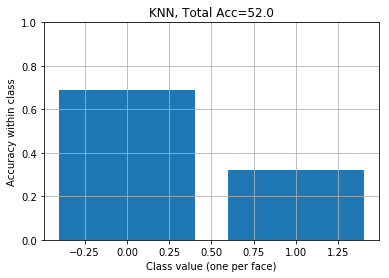

In [55]:
from sklearn.decomposition import PCA 
from sklearn.pipeline import Pipeline

def per_class_accuracy(ytrue,yhat):
    conf = mt.confusion_matrix(ytrue,yhat)
    norm_conf = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]
    return np.diag(norm_conf)

def plot_class_acc(ytrue,yhat, title=''):
    acc_list = per_class_accuracy(ytrue,yhat)
    plt.bar(range(len(acc_list)), acc_list)
    plt.xlabel('Class value (one per face)')
    plt.ylabel('Accuracy within class')
    plt.title(title+", Total Acc=%.1f"%(100*mt.accuracy_score(ytrue,yhat)))
    plt.grid()
    plt.ylim([0,1])
    plt.show()
    
plot_class_acc(y_v, yhat, title="KNN")

In [59]:
%%time
# creating odd list of K for KNN
myList = list(range(1,50))

# subsetting just the odd ones
neighbors = filter(lambda x: x % 2 != 0, myList)

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, x_train, y_train, cv = 10, scoring = 'accuracy')
    cv_scores.append(scores.mean())
    print("K:", k)

K: 1
K: 3
K: 5
K: 7
K: 9
K: 11
K: 13
K: 15
K: 17
K: 19
K: 21
K: 23
K: 25
K: 27
K: 29
K: 31
K: 33
K: 35
K: 37
K: 39
K: 41
K: 43
K: 45
K: 47
K: 49
Wall time: 1h 36min 30s


The optimal number of neighbors is 47


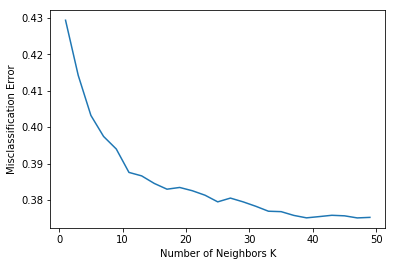

In [110]:
# changing to misclassification error
MSE = [1 - x for x in cv_scores]
neighbors = list(neighbors)

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print("The optimal number of neighbors is", optimal_k)

# plot misclassification error vs k
plt.plot(neighbors, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()


In [107]:
kdt = KDTree(x_t, leaf_size = 30, metric = 'euclidean')


In [ ]:

ind = kdt.query(x_v[0:100], k = 3, return_distance=False)



In [106]:
print(ind)

[[    0 17292 53448]
 [    1 55555 49399]
 [    2 52738 33680]
 [    3 56499  5463]
 [    4 24952 21406]
 [    5 38974  4265]
 [    6 52151 57055]
 [    7  1307  1669]
 [    8   307 59173]
 [    9 43553 49180]
 [   10 35170  1350]
 [   11 20288 16113]
 [   12 34065 33057]
 [   13  8458 14759]
 [   14 49543 13930]
 [   15 13083 39364]
 [   16 37124 20152]
 [   17 20738 19061]
 [   18 60111  2059]
 [   19  1168 44846]
 [   20 44222 17289]
 [   21 23998  4629]
 [   22 15887 57154]
 [   23 42578 40842]
 [   24 41823 10974]
 [   25 51454  9053]
 [   26 19107 44366]
 [   27  2398 28580]
 [   28 24466  8502]
 [   29 17536 47240]
 [   30  5823 23233]
 [   31 48442  1198]
 [   32  4390 43073]
 [   33   749   582]
 [   34  6569 19329]
 [   35 15036 35663]
 [   36 17485  3162]
 [   37 52352 55908]
 [   38 19562  2264]
 [   39   403  5758]
 [   40 10771  7427]
 [   41 20959  2739]
 [   42 29759 48955]
 [   43 38318 50938]
 [   44 60680 19871]
 [   45 39208 40223]
 [   46 42481 36450]
 [   47 31173